In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
from gurobipy import *
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
from rsome import cpt_solver as cpt

In [2]:
# data_generation_process = "SPO_Data_Generation"
data_generation_process = "DDR_Data_Generation"

# Parameters

In [3]:
# import pyepo
# generate data
grid = (5,5) # grid size
num_train = 50 # number of training data
num_feat = 5 # size of feature
num_test = 1000
deg = 1.0 # polynomial degree
e = 10 # scale of normal std or the range of uniform. For the error term
lower = 0.9 # coef lower bound
upper = 1 # coef upper bound
p = num_feat # num of features
d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
alpha = e # scale of normal std or the range of uniform. For the error term
mis = deg # model misspecification
coef_seed = 1

In [4]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
grandparent_directory = os.path.dirname(parent_directory)
DataPath = os.path.dirname(grandparent_directory) + '/Data/Test_0324' + data_generation_process + "/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
print("grandparent_directory:", grandparent_directory)
print("DataPath:", DataPath)
DataPath = DataPath + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_coef_seed="+str(coef_seed)+"/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)

grandparent_directory: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Code_MacBook
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Test_0324DDR_Data_Generation/


# Generate Data

In [ ]:
def Prepare_Data(DataPath,lower, upper, p, d, coef_seed,seed_all,num_test, num_train, alpha,mis,data_generation_process):
# #  ****** Coef generation *********
    from Data import data_generation
    data_gen = data_generation()
    # print("W_star = ",W_star[0,:])
    W_star = data_gen.generate_truth(DataPath,lower, upper, p, d, coef_seed,version = 0) 

    x_test_all = {}; c_test_all = {}; x_train_all = {}; c_train_all = {}; W_star_all = {}
    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        # #  ****** Data generation *********
        x_test_all[seed], c_test_all[seed], x_train_all[seed], c_train_all[seed], W_star_all[seed] = data_gen.generate_samples(seed,DataPath_seed,p, d, num_test, num_train, alpha, W_star, mis, thres = 10, 
                                version = data_generation_process, x_dist = 'normal', e_dist = 'normal', x_low = 0, x_up = 2, x_mean = 2, x_var = 0.25, bump = 100) 
        # print()
    return x_test_all, c_test_all, x_train_all, c_train_all, W_star_all

# Robustness Formulation

### Define network

In [6]:
def _getArcs(grid):
    arcs = []
    for i in range(grid[0]):
        # edges on rows
        for j in range(grid[1] - 1):
            v = i * grid[1] + j
            arcs.append((v, v + 1))
        # edges in columns
        if i == grid[0] - 1:
            continue
        for j in range(grid[1]):
            v = i * grid[1] + j
            arcs.append((v, v + grid[1]))

    arc_index_mapping = {}
    for i in range(len(arcs)):
        arc = arcs[i]
        arc_index_mapping[arc] = i

    return arcs,arc_index_mapping

## Solve the model with OLS estimation, the objective can be used as target

$\min \frac{1}{N} \sum_{n \in [N]}[\mu y_{n}^{\top}\tilde{z}_{n} + (1 - \mu )y_{n}^\top f(\tilde{x}_{n},w^{OLS})]$

In [7]:
def Solve_DDR_inner(arcs,arc_index_mapping,mu,num_train,num_arcs,c_train,x_train,W_ols,w0_ols,grid):
    model = ro.Model()            # create an RSOME model
    y = model.dvar((num_train,num_arcs))
    t = model.dvar()
    weight_sum = model.dvar(num_train)                   

    for i in range(num_train):
        model.st(weight_sum[i] == mu * (y[i,:] @ c_train[i,:]) + (1 - mu) *  y[i,:] @ (W_ols @ x_train[i,:] + w0_ols))
    model.st(t == weight_sum.sum() * (1/num_train))
    model.st(y >= 0)

    # shortest path constraints
    for n in range(num_train):
        for i in range(grid[0]):
            for j in range(grid[1]):
                v = i * grid[1] + j
                expr = 0
                for arc in arcs:
                    # flow in
                    if v == arc[1]:
                        expr += y[n,arc_index_mapping[arc]]
                    # flow out
                    elif v == arc[0]:
                        expr -= y[n,arc_index_mapping[arc]]
                # source
                if i == 0 and j == 0:
                    model.st(expr == -1)
                # sink
                elif i == grid[0] - 1 and j == grid[0] - 1:
                    model.st(expr == 1)
                # transition
                else:
                    model.st(expr == 0)

    model.min(t) 

    model.solve(grb)
    y_sol = y.get()
    obj = model.obj()
    # print("obj = ",obj)

    # i = 1
    # path = []
    # for j in range(num_arcs):
    #     if y_sol[i,j] > 0:
    #         path.append(arcs[j])
    # print("The",i,"Sample: shortest path = ",path)
    return obj,y_sol

## Solve Sub-RDDR

In [8]:
def solve_sub_rddr(arcs,arc_index_mapping,mu,rho,num_train,num_arcs,c_train,x_train,grid,is_binary):
    model = ro.Model()            # create an RSOME model
    if is_binary:
        y = model.dvar((num_train,num_arcs),vtype='B')
    else:
        y = model.dvar((num_train,num_arcs))
    t = model.dvar()
    gamma = model.dvar()
    delta = model.dvar((num_train,num_arcs))
    delta_vector = model.dvar(num_train * num_arcs)
    weight_sum = model.dvar(num_train)                   

    for i in range(num_train):
        model.st(weight_sum[i] == mu * (y[i,:] @ c_train[i,:]) + (1 - mu) *  delta[i,:] @ c_train[i,:])
    model.st(y >= 0)
    model.st(t >= weight_sum.sum() * (1/num_train) + ((1-mu)/num_train)*rho*gamma)

    for j in range(num_arcs):
        model.st(delta[:,j].sum() == y[:,j].sum())
        model.st(x_train.T @ delta[:,j] == x_train.T @ y[:,j])

    index = 0
    for i in range(num_train):
        for j in range(num_arcs):
            model.st(delta_vector[index] == delta[i,j])
            index = index + 1
    model.st(rso.norm(delta_vector,2) <= gamma)        # a constraint with 2-norm terms
    model.st(gamma >= 0)


    # shortest path constraints
    for n in range(num_train):
        for i in range(grid[0]):
            for j in range(grid[1]):
                v = i * grid[1] + j
                expr = 0
                for arc in arcs:
                    # flow in
                    if v == arc[1]:
                        expr += y[n,arc_index_mapping[arc]]
                    # flow out
                    elif v == arc[0]:
                        expr -= y[n,arc_index_mapping[arc]]
                # source
                if i == 0 and j == 0:
                    model.st(expr == -1)
                # sink
                elif i == grid[0] - 1 and j == grid[0] - 1:
                    model.st(expr == 1)
                # transition
                else:
                    model.st(expr == 0)

    model.min(t) 
    model.solve(cpt,display=False,log=False)
    y_sol = y.get()
    obj = model.obj()
    # print("obj = ",obj)
    return obj,y_sol

## RobustW

In [9]:
def solve_robustW(mu,rho,num_train,num_arcs,num_feat,c_train,x_train,y_sol):
    model = ro.Model()            # create an RSOME model

    W_DDR = model.dvar((num_arcs,num_feat))
    W0_DDR = model.dvar(num_arcs)
    norm_vector = model.dvar(num_train*num_arcs)
    t = model.dvar()
    weight_sum = model.dvar(num_train)                   

    for i in range(num_train):
        model.st(weight_sum[i] == mu * (y_sol[i,:] @ c_train[i,:]) + (1 - mu) *  y_sol[i,:] @ (W_DDR @ x_train[i,:] + W0_DDR))
    model.st(t == weight_sum.sum() * (1/num_train))

    for i in range(num_train):
        model.st(norm_vector[i*num_arcs:(i+1)*num_arcs] == c_train[i,:] - W_DDR @ x_train[i,:] - W0_DDR)
    model.st(rso.norm(norm_vector,2) <= rho)

    model.max(t) 

    model.solve(cpt,display=False,log=False)
    obj = model.obj()
    # print("obj = ",obj)
    W_DDR_val = W_DDR.get()
    W0_DDR_val = W0_DDR.get()
    return obj,W_DDR_val,W0_DDR_val

# Compute out-of-sample performance

In [10]:
arcs,arc_index_mapping = _getArcs(grid)
num_arcs = len(arcs)

seed_all = np.arange(1,20)
# obtain data
x_test_all, c_test_all, x_train_all, c_train_all, W_star_all = Prepare_Data(DataPath,lower, upper, p, d, coef_seed,seed_all,num_test, num_train, alpha,mis,data_generation_process)

In [11]:
from OLS import ols_method
ols_method_obj = ols_method()
from Peformance import performance_evaluation
perfs = performance_evaluation()
W_ols_all = {}; w0_ols_all = {}; t_ols_all = {}; obj_ols_all = {}; rho_lb_all = {}
cost_OLS_all = {}; cost_Oracle_all = {}

for seed in seed_all:
    # compute OLS performance
    W_ols_all[seed], w0_ols_all[seed], t_ols_all[seed], obj_ols_all[seed] = ols_method_obj.ols_solver("",x_train_all[seed], c_train_all[seed])
    cost_OLS_all[seed] = perfs.compute_Cost_with_Prediction(arcs,w0_ols_all[seed],W_ols_all[seed], grid,c_test_all[seed],x_test_all[seed])
    cost_Oracle_all[seed] = perfs.compute_Oracel_Cost(arcs, grid,c_test_all[seed])

    # obtain the lowest rho
    # is_binary = False
    rho_lb_all[seed] =  np.sqrt(obj_ols_all[seed] * num_train) 

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13


In [12]:
def obtain_out_of_sample_performance(seed,mu,rho_lb,rho_coef_all,is_binary,arcs,arc_index_mapping,grid,x_train_all,c_train_all,x_test_all,c_test_all,cost_OLS,cost_Oracle,perfs):
    x_train = x_train_all[seed]
    c_train = c_train_all[seed]
    x_test = x_test_all[seed]
    c_test = c_test_all[seed]

    regret_arr = np.zeros(len(rho_coef_all)), 
    cost_DDR = {}
    rho_index = 0
    for rho_coef in rho_coef_all:
        rho = rho_lb + rho_coef * rho_lb
    
        obj_rddr,y_sol_rddr = solve_sub_rddr(arcs,arc_index_mapping,mu,rho,num_train,num_arcs,c_train,x_train,grid,is_binary)
        obj,W_DDR,W0_DDR = solve_robustW(mu,rho,num_train,num_arcs,num_feat,c_train,x_train,y_sol_rddr)
        cost_DDR[rho_coef] = perfs.compute_Cost_with_Prediction(arcs,W0_DDR,W_DDR, grid,c_test,x_test)
        # regret = (np.nanmean(cost_OLS) - np.nanmean(cost_DDR[rho_coef]))/(np.nanmean(cost_OLS) - np.nanmean(cost_Oracle)) * 100
        # print("seed=",seed,",mu=",mu,"rho=",rho,",regret=",np.round(regret,4))
        # regret_arr[rho_index] = regret
        rho_index = rho_index +1
    return cost_DDR

In [13]:
seed_all = np.arange(1,20)

In [18]:
mu = 0.5
rho_coef_all = np.round(np.arange(0.0,0.001,0.0001),4)
is_binary = False
regret_DDR_all = {}; cost_DDR_all = {}
regret_DDR_avg = np.zeros(len(rho_coef_all)) 
for seed in seed_all:
    cost_DDR_all[seed,mu] = obtain_out_of_sample_performance(seed,mu,rho_lb_all[seed],rho_coef_all,is_binary,arcs,arc_index_mapping,grid,x_train_all,c_train_all,x_test_all,c_test_all,cost_OLS_all[seed],cost_Oracle_all[seed],perfs)
    regret_tem = np.zeros(len(rho_coef_all)) 
    rho_index = 0
    for rho_coef in rho_coef_all:
        regret = (np.nanmean(cost_OLS_all[seed]) - np.nanmean(cost_DDR_all[seed,mu][rho_coef]))/(np.nanmean(cost_OLS_all[seed]) - np.nanmean(cost_Oracle_all[seed])) * 100
        # print("seed=",seed,",mu=",mu,"rho_coef=",rho_coef,",regret=",np.round(regret,4))
        regret_tem[rho_index] = regret
        rho_index = rho_index +1
    print("seed=",seed,",mu=",mu,",regret =",np.round(regret_tem,4))
    regret_DDR_avg = regret_DDR_avg + regret_tem
regret_DDR_avg = regret_DDR_avg/len(seed_all)
print("mu=",mu,",avg regret  =",np.round(regret_DDR_avg,4))


seed= 1 ,mu= 0.5 ,regret = [ 0.0259 -0.2896 -0.51   -0.4932 -0.0015 -0.2736  0.0481  0.0999  0.0286
  0.2294]
seed= 2 ,mu= 0.5 ,regret = [-0.0778  0.2465  0.1433  0.0182  0.3012  0.4268  0.5323  0.8334  0.7561
  0.5495]
seed= 3 ,mu= 0.5 ,regret = [0.1017 0.348  0.4128 0.141  0.347  0.4138 0.328  0.1903 0.5221 0.4721]
seed= 4 ,mu= 0.5 ,regret = [0.     0.1277 0.0616 0.3615 0.3641 0.6538 0.5894 0.4344 0.1563 0.1943]
seed= 5 ,mu= 0.5 ,regret = [ 0.0338 -0.0051 -0.1047  0.1221  0.2003  0.2353 -0.0489 -0.0613 -0.0191
  0.0838]
seed= 6 ,mu= 0.5 ,regret = [ 0.0177 -0.2004  0.0894 -0.1376 -0.1304 -0.1221  0.2778  0.2767  0.1972
  0.2479]
seed= 7 ,mu= 0.5 ,regret = [-0.1039  0.2362  0.4896  0.2165  0.2974  0.3422  0.0907  0.5445  0.5159
  0.6165]
seed= 8 ,mu= 0.5 ,regret = [-0.0063  0.0115 -0.4066 -0.6603 -0.6769 -0.6735 -0.9094 -0.9461 -1.0574
 -1.0522]
seed= 9 ,mu= 0.5 ,regret = [ 0.0068 -1.0808 -1.0209 -1.2477 -1.2286 -1.2816 -1.2379 -1.169  -1.1196
 -1.0448]
seed= 10 ,mu= 0.5 ,regret = [-0.

In [15]:
def cross_compare2plus(c_item, c_base, c_oracle):
    c_item = np.asarray(c_item)
    c_base = np.asarray(c_base)
    c_oracle = np.asarray(c_oracle)

    N = len(c_item)
    c_diff = c_item - c_base
    lbel = np.zeros((N,1))
    
    equals = np.sum(c_diff == 0)
    wins = np.sum(c_diff < 0)
    lose = np.sum(c_diff > 0)
    
    lbel[c_diff < 0] = 1
    lbel[c_diff > 0] = -1
    
    # print("Num_train =",N,",Num_equals =",equals,",Num_wins =",wins,",Num_lose =",lose)
    # print("base cost = ", np.mean(c_base),",item cost = ",np.mean(c_item))
    if N == equals:
        win_ratio = 0.5
    else:
        win_ratio = wins/(N - equals)
    # cost_reduction = (np.mean(c_base) - np.mean(c_item) )/np.abs(np.mean(c_oracle))
    regret_reduction = (np.nanmean(c_base) - np.nanmean(c_item))/np.abs(np.nanmean(c_base) - np.nanmean(c_oracle))
    return lbel, win_ratio, regret_reduction

In [16]:
H2H_DDR_vs_OLS_all = {}; regret_reduction_DDR_vs_OLS_all = {}
for rho_coef in rho_coef_all:
    H2H_DDR_vs_OLS_arr = np.zeros(len(seed_all)); regret_reduction_DDR_vs_OLS_arr = np.zeros(len(seed_all))
    seed_index = 0
    print("rho_coef = ",rho_coef)
    for seed in seed_all:
        lbel, H2H_DDR_vs_OLS_arr[seed_index], H2H_DDR_vs_OLS_arr[seed_index] = cross_compare2plus(cost_DDR_all[seed,mu][rho_coef],cost_OLS_all[seed], cost_Oracle_all[seed])
        seed_index = seed_index + 1
    H2H_DDR_vs_OLS_all[mu,rho_coef] = H2H_DDR_vs_OLS_arr; regret_reduction_DDR_vs_OLS_all[mu,rho_coef] = H2H_DDR_vs_OLS_arr

rho_coef =  0.0
rho_coef =  0.0001
rho_coef =  0.0002
rho_coef =  0.0003
rho_coef =  0.0004
rho_coef =  0.0005
rho_coef =  0.0006
rho_coef =  0.0007
rho_coef =  0.0008
rho_coef =  0.0009


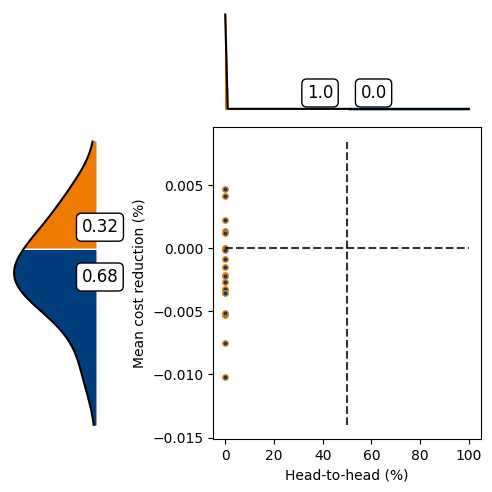

In [17]:
rho_coef = rho_coef_all[1]
import Figures
Figures.figure_plot_upleft(H2H_DDR_vs_OLS_all[mu,rho_coef], regret_reduction_DDR_vs_OLS_all[mu,rho_coef], "", size = (5, 5), move = [-0.12, 0.04, 0.35, 0.55], 
                    ysame = 0, yrange = [6,6], sublabel = '', ypio = 0)